In [74]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [75]:
import numpy as np
import pandas as pd

In [76]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Precipitation (Inches)')

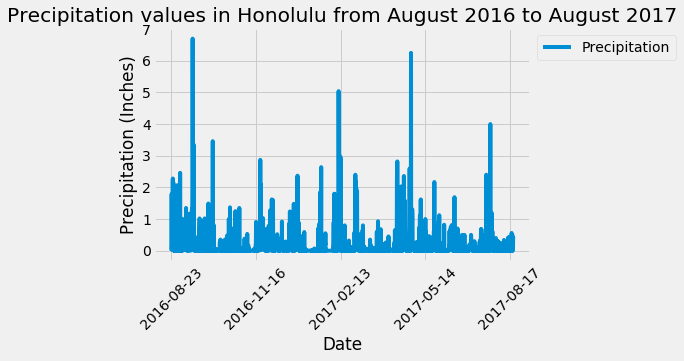

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
all_dates = session.query(Measurement.date).all()
most_recent_date = all_dates[-1][0]
year_before_date_datetime = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query_prcps = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= year_before_date_datetime).filter\
    (Measurement.date <= most_recent_date).all()
        
# Save the query results as a Pandas DataFrame and set the index to the date column
dates_prcps = []
prcps = []
for x in query_prcps:
    dates_prcps.append(x[0])
    prcps.append(x[1])
    
prcps_df = pd.DataFrame({'Date':dates_prcps,'Precipitation':prcps})
prcps_df.set_index('Date',inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
prcps_df.sort_values('Date',inplace=True)
prcps_df.dropna(how='any',inplace=True)
prcps_df.plot()
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1,1))
plt.title('Precipitation values in Honolulu from August 2016 to August 2017')
plt.ylabel('Precipitation (Inches)')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [12]:
# Design a query to show how many stations are available in this dataset?
station_count_query = session.query(Station.station).count()
station_list_query = session.query(Station.name).all()

print(f'There are  {station_count_query} stations and they are {station_list_query}')

There are  9 stations and they are [('WAIKIKI 717.2, HI US',), ('KANEOHE 838.1, HI US',), ('KUALOA RANCH HEADQUARTERS 886.9, HI US',), ('PEARL CITY, HI US',), ('UPPER WAHIAWA 874.3, HI US',), ('WAIMANALO EXPERIMENTAL FARM, HI US',), ('WAIHEE 837.5, HI US',), ('HONOLULU OBSERVATORY 702.2, HI US',), ('MANOA LYON ARBO 785.2, HI US',)]


In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_codes = [x[0] for x in session.query(Station.station).all()]
station_counts = []
for i in station_codes:
    counts_query = session.query(func.count(Measurement.station)).filter(Measurement.station == i).all()
    station_counts.append(counts_query[0][0])
station_counts_df = pd.DataFrame({'Station':station_codes,'Count':station_counts})
sorted_station_counts_df = station_counts_df.sort_values('Count',ascending=False)
sorted_station_counts_df.reset_index(inplace=True)
sorted_station_counts_df

['USC00519397',
 'USC00513117',
 'USC00514830',
 'USC00517948',
 'USC00518838',
 'USC00519523',
 'USC00519281',
 'USC00511918',
 'USC00516128']

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = sorted_station_counts_df['Station'][0]
lowest_temperature = session.query(func.min(Measurement.tobs)).filter\
                    (Measurement.station == most_active_station).all()
highest_temperature = session.query(func.max(Measurement.tobs)).filter\
                    (Measurement.station == most_active_station).all()
print(f'The most active station is {most_active_station}. Its highest recorded temp was {highest_temperature}, and its lowest recorded temp was {lowest_temperature}.')

The most active station is USC00519281. Its highest recorded temp was [(85.0,)], and its lowest recorded temp was [(54.0,)].


Text(0.5, 0, 'Temperature')

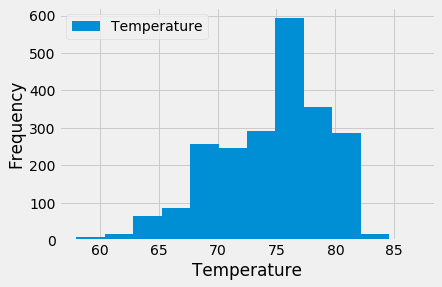

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_temps = session.query(Measurement.date,Measurement.tobs).filter(Measurement.date >= year_before_date_datetime).filter\
    (Measurement.date <= most_recent_date).all()

dates_temps = []
temps = []
for x in query_temps:
    dates_temps.append(x[0])
    temps.append(x[1])

temps_df = pd.DataFrame({'Date':dates_temps,'Temperature':temps})
temps_df.set_index('Date',inplace=True)
temps_df.plot(kind='hist',bins=12)
plt.xlabel('Temperature')

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
min_temp,avg_temp,max_temp = calc_temps('2017-07-17','2017-07-26')[0]

Text(0.5, 1.0, 'Temperatures for 2017-07-17 to 2017-07-26')

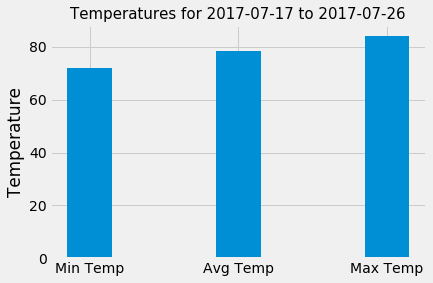

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
labels = ['Min Temp', 'Avg Temp', 'Max Temp']
plt.bar(labels,[min_temp,avg_temp,max_temp],width=.3)
plt.ylabel('Temperature')
plt.title('Temperatures for 2017-07-17 to 2017-07-26', fontsize = 15)

In [68]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfalls = []
latitudes = []
longitudes = []
elevations = []
station_names = []
for x in station_codes:
    total_rainfall = session.query(func.sum(Measurement.tobs)).filter(Measurement.station == x).filter(Measurement.date >= '2017-07-17').filter(Measurement.date <= '2017-07-26').all()[0]
    
    total_rainfalls.append(total_rainfall[0])
    
for x in station_codes:
    station_name,latitude,longitude,elevation = session.query(Station.name,Station.latitude,Station.longitude,Station.elevation).\
    filter(Station.station == x).all()[0]
    
    latitudes.append(latitude)
    longitudes.append(longitude)
    elevations.append(elevation)
    station_names.append(station_name)
    
    
total_rainfalls_df = pd.DataFrame({'Station Code':station_codes,'Station Name':station_names,'Total Rainfall':total_rainfalls,
                                  'Latitude':latitudes,'Longitude':longitudes,'Elevation':elevations})
total_rainfalls_df.sort_values('Total Rainfall',ascending=False,inplace=True)
total_rainfalls_df.reset_index(drop=True,inplace=True)
total_rainfalls_df

,Station Code,Station Name,Total Rainfall,Latitude,Longitude,Elevation
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",802.0,21.52130,-157.83740,7.0
1,USC00513117,"KANEOHE 838.1, HI US",774.0,21.42340,-157.80150,14.6
2,USC00519281,"WAIHEE 837.5, HI US",768.0,21.45167,-157.84889,32.9
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",749.0,21.33310,-157.80250,152.4
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",726.0,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",722.0,21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",479.0,21.39340,-157.97510,11.9
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",NaN,21.49920,-158.01110,306.6
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",NaN,21.31520,-157.99920,0.9


In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [87]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
trip_dates = []
start_date = dt.datetime(2018,7,17)
for x in range(10):
    trip_dates.append(start_date + dt.timedelta(days=x))
# Stip off the year and save a list of %m-%d strings
striped_dates_trip = []
for x in trip_dates:
    striped_dates_trip.append(x.strftime('%m-%d'))
# Loop through the list of %m-%d strings and calculate the normals for each date
min_temps_trip = []
avg_temps_trip = []
max_temps_trip = []
for x in striped_dates_trip:
    min_temp,avg_temp,max_temp = daily_normals(x)[0]
    
    min_temps_trip.append(min_temp)
    avg_temps_trip.append(avg_temp)
    max_temps_trip.append(max_temp)

In [98]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_trip_temps = pd.DataFrame({'Dates':trip_dates,'Historical Min Temp':min_temps_trip,
                                 'Historical Avg Temp':avg_temps_trip,'Historical Max Temp':max_temps_trip})
daily_trip_temps.set_index('Dates',inplace=True)
daily_trip_temps

,Historical Min Temp,Historical Avg Temp,Historical Max Temp
Dates,,,
2018-07-17,70.0,76.301887,83.0
2018-07-18,72.0,76.637931,83.0
2018-07-19,68.0,75.890909,83.0
2018-07-20,69.0,75.462963,82.0
2018-07-21,69.0,76.924528,83.0
2018-07-22,69.0,75.788462,81.0
2018-07-23,70.0,76.203704,84.0
2018-07-24,69.0,76.555556,81.0
2018-07-25,67.0,76.890909,84.0


Text(0, 0.5, 'Temperature')

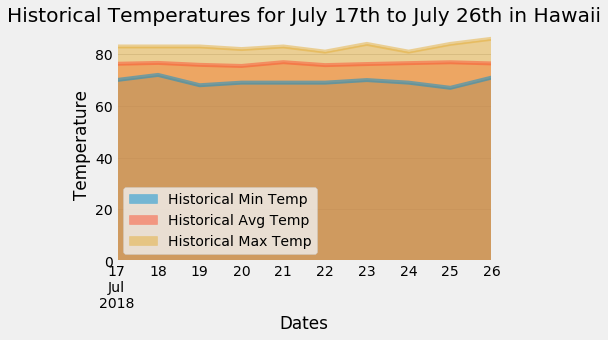

In [102]:
# Plot the daily normals as an area plot with `stacked=False`
daily_trip_temps.plot.area(stacked=False)
plt.title('Historical Temperatures for July 17th to July 26th in Hawaii')
plt.ylabel('Temperature')